# Cheng Hsuan Chiang 
# ID: 12283758
# Homework3: Financial Ratio Quantile Strategies

## University of Chicago - Financial Mathematics
## FINM 33150 - Regression Analysis and Quantitative Trading Strategies

### Period: January 2014 - Jan 2021

## 0.1 Understand Your Data

• Read all documentation webpages for Zacks Fundamentals B.<br> 
• You will see they supply 6 related tables, **FC**, **FR**, **MT**, **MKTV**, **SHRC** and **HDM**.<br> 
• The strategy coding for this assignment will be reasonably easy.<br>
• The data assembly, deliberately, is the difficult part.<br> 

## 0.2: Define the Universe

**Choose at least 200 tickers of US equities such that they satisfy the following:** <br>


• end-of-day adjusted closing prices are available, over the entire period Jan 2014 through Jan 2021<br>
• debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2014 through Jan 2021 (preferably more than fleetingly)<br>
• Not in the automotive, financial or insurance sector, over the entire period Jan 2014 through Jan 2021<br>
• Has feasible calculation of the ratios specified below, over the entire period Jan 2014 through Jan 2021, including for at least one PER_END_DATE no more than one year old. Debt ratio of zero is OK.<br>

## 0.3: Select Financial Ratios

**For this assignment, we will work with the following ratios: <br>**

Debt to market cap<br>
Return on investment<br>
Price to earnings<br>
Ratio Combination: We will use z-scores of Debt to Market cap, Return on Investment and price to earnings for our strategy

# 1. Process data and calculate daily ratios $\frac{D}{E}$, $\frac{P}{E}$, $ROI$

$$ DE = \frac{D}{E} = \frac{\text{Total Debt}}{\text{Mkt Cap}} $$

$$ PE = \frac{P}{E} = \frac{\text{Mkt Cap}}{\text{Net Income}} = \frac{\text{Price}}{\text{EPS (diluted/basic)}} $$

$$ ROI = \frac{\text{Operating Income}}{\text{Mkt Cap + LT Debt (net/total)}} $$

**First we retrieve all necessary packages, imports and Functions:**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from   matplotlib                import pyplot as plt
from   urllib.request            import urlretrieve
import pandas                    as     pd
import numpy                     as     np
import seaborn                   as     sns
import statsmodels.api           as     sm
import quandl
import scipy
import sys
import requests
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
quandl.ApiConfig.api_key = "CPkrEDEshfeXucLHHk_T"

In [2]:
## We will download available the ticker universe from ZACKES tickers
tickers_universe    = pd.read_csv('http://static.quandl.com/zacks/zacks-tickers.csv', names=['Symbol', 'Name'])[['Symbol']]['Symbol'].tolist()
## We will exclude automotive(5) and financial(13) sector
excluding_sectors   = [5, 13]
## We will use end-of-day adjusted closing prices over the entire period Jan 2014 through Jan 2021
period              = ['2014-01-02','2021-01-29']

data_start          = '2013-09-30'
data_end            = '2021-03-31'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
## We will download data from quandl, and remove irrelevant sectors and timeframes for multiple securities.
## ticker_list: list of tickers, start: starting close price, end: ending close price, fiscal: earliest quarter-end to encompass, excluding_sectors: sectors to exclude
def choose_tickers(ticker_list,start,end,fiscal,excluding_sectors):
    data = quandl.get_table("ZACKS/FC", paginate = True, per_end_date = {'gte':fiscal}, per_type = 'Q', qopts = {'columns': ['ticker','zacks_sector_code','per_end_date','per_type']}, ticker = ticker_list,)
    datadcleaning = data.groupby('ticker').agg(['nunique'])
    datadcleaning = datadcleaning[datadcleaning[('zacks_sector_code', 'nunique')] != 1]
    data = data.set_index('ticker')
    data = data.drop(index=datadcleaning.index)
    data = data.reset_index()
    data = data.drop_duplicates(subset=['ticker','zacks_sector_code','per_type'])
    
    data = data[(data['zacks_sector_code'].isin(excluding_sectors) == False)]
    data = data.reset_index(drop=True)
    
    mask = []
    for d in range(data.shape[0]):
        try:
            valid_check = quandler_table(data.iloc[d,0],start,end)
            if (valid_check.shape[0] == valid_check.dropna().shape[0]) & (valid_check.iloc[0,1] == pd.to_datetime(end)) & ((valid_check.iloc[-1,1] == pd.to_datetime(start))):
                pass
            else:
                mask.append(d)
        except:
            mask.append(d)
    
    data = data.drop(data.index[mask])
    return data

## We will download ZACKS/FR data.
def ZACKS_FR(ticker_list,fiscal,fiscallast):
    data = quandl.get_table("ZACKS/FR", paginate = True, per_end_date = {'gte':fiscal, 'lt':fiscallast}, qopts = {'columns': ['ticker','per_end_date','per_type','ret_invst','tot_debt_tot_equity']}, ticker = ticker_list,)
    return data

## We will download ZACKS/MKTV data.
def ZACKS_MKTV(ticker_list,fiscal,fiscallast):
    data = quandl.get_table("ZACKS/MKTV", paginate = True, per_end_date = {'gte':fiscal,'lt':fiscallast}, qopts = {'columns': ['ticker','per_end_date','per_type','mkt_val']}, ticker = ticker_list,)
    return data

## We will download ZACKS/FC data.
def ZACKS_FC(ticker_list,fiscal,fiscallast):
    data = quandl.get_table("ZACKS/FC", paginate = True, per_end_date = {'gte':fiscal,'lt':fiscallast}, qopts = {'columns': ['ticker','per_end_date','per_type','filing_date','tot_lterm_debt','net_lterm_debt','eps_diluted_net','basic_net_eps']}, ticker = ticker_list,)
    return data
## We will download ZACKS/SH data.
def ZACKS_SH(ticker_list,fiscal,fiscallast):
    data = quandl.get_table("ZACKS/SHRS", paginate = True, per_end_date = {'gte':fiscal,'lt':fiscallast}, qopts = {'columns': ['ticker','shares_out','per_end_date','per_type']}, ticker = ticker_list,)
    return data
## We will download QUOTEMEDIA/PRICES data.
def quandler_table(ticker_list,start_date,end_date):
    data = quandl.get_table("QUOTEMEDIA/PRICES", paginate = True, qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, ticker = ticker_list, date = {'gte': start_date, 'lte': end_date})
    return data

## We will bulk download adjusted close price data.
def get_table(dataset_code: str, database_code: str = "ZACKS", start_date = "2014-01-02", end_date = "2021-01-31"):
    url = (f"https://data.nasdaq.com/api/v3/datatables/{database_code}/{dataset_code}.json?date.gte={start_date}&date.lte={end_date}")
    get = requests.get(url, params={ "api_key": "CPkrEDEshfeXucLHHk_T", "qopts.export": "true",})
    data = get.json()
    print(data)
    urlretrieve(data["datatable_bulk_download"]["file"]["link"],f"zacks_{dataset_code.lower()}.zip",)

## We will load adjusted close price bulk data directly from csv file.
def load_file(path):
    df = (pd.read_csv(path, low_memory=False))
    return df

**We will create functions to analyze quantile trading strategies below.**

In [4]:
## We will provides statistics for a given simulation.
## data = M-day return spread data from Quandl, q: level of significance for Value at Risk
def table_statistics(data, q):
    df                                            = data.copy()    
    df.index                                      = data.index.date
    statistics                                    = pd.DataFrame(columns = df.columns)
    statistics.loc['Mean']                        = df.mean()
    statistics.loc['Median']                      = df.median()
    statistics.loc['Max']                         = df.max()
    statistics.loc['75% Quantile']                = df.quantile(0.75)
    statistics.loc['Min']                         = df.min()
    statistics.loc['Std.Dev']                     = df.std()
    statistics.loc['Skewness']                    = df.skew()
    statistics.loc['Excess Kurtosis']             = df.kurtosis()    
    statistics.loc['VaR (Quantile {})'.format(q)] = df.quantile(q)
    statistics.loc['VaR (Normal)']                = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    return round(statistics,3)

## We will provides maxdrawdown statistics for a given simulation.
## This is from Mark Hendrick's class
def table_maxdrawdown(data, q, returns=True):
    df                                           = data.copy()
    df.index                                     = data.index.date
    report                                       = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness']                       = df.skew()
    report.loc['Excess Kurtosis']                = df.kurtosis()
    report.loc['VaR (Q{})'.format(q)]            = df.quantile(q)
    report.loc['VaR (N{})'.format(q)]            = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    report.loc['Expected Shortfall']             = df[df < df.quantile(q)].mean()
    
    if returns == True:
        cum_ret                                  = (1 + df).cumprod()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max) / rolling_max
    else:
        cum_ret                                  = df.cumsum()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max)
         
    report.loc['Max Drawdown']                   = drawdown.min()
    report.loc['Max Drawdown Start']                      = None
    report.loc['Max Drawdown End']                        = drawdown.idxmin()
    report.loc['Recovery Date']                  = None
    report.loc['Single Largest Drawdown']        = df.min()
    report.loc['Single Largest Drawdown Date']   = df.idxmin()
    
    for col in df.columns:
        report.loc['Max Drawdown Start', col]             = (rolling_max.loc[:report.loc['Max Drawdown End', col]])[col].idxmax()
        recovery_df                              = (drawdown.loc[report.loc['Max Drawdown End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col]     = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['Max Drawdown Start']).dt.days

        except:
            report.loc['Recovery Date', col]     = None
            report.loc['Recovery period (days)'] = None
    return round(report,3)

## We will provides performance Metrics for a given simulation.
## This is from Mark Hendrick's class
def performanceMetrics(returns, annualization = 12):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)
    metrics['Sortino'] = (returns.mean() / returns[returns < 0].std()) * np.sqrt(annualization)
    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    metrics.sort_values('Sharpe',ascending = False)
    return metrics

In [5]:
## We will calculate the daily and cumulative returns and returns a dataframe which can be used to calculate performance statistics later.
def Return_Conversion(df):
    df = df.groupby('trade dates').agg({'PL_DLY':'sum'})
    df = df.assign(PL_LTD = df['PL_DLY'].cumsum())
    df = df.assign(Portfolio_Value = df['PL_LTD'] + 10000000)
    df = df.assign(Ret_DLY = np.log(df['Portfolio_Value']/df['Portfolio_Value'].shift()))
    df = df.assign(Ret_LTD = np.log(df['Portfolio_Value']/10000000))
    df = df.dropna()
    return df

##  We will calculate daily returns for multiple quantile trading strategies and returns one dataframe.
def Daily_Return(df,name):
    df2 = df.groupby('trade dates').agg({'PL_DLY':'sum'})
    df_ret = pd.DataFrame(index=df2.index,columns=["{}_DailyReturn".format(name)])
    df_ret["{}_DailyReturn".format(name)] =  Return_Conversion(df)[['Ret_DLY']]
    return df_ret.dropna()

##  We will calculate daily returns for multiple strategies and returns one dataframe.
def Daily_ProfitandLoss(df,name):
    df2 = df.groupby('trade dates').agg({'PL_DLY':'sum'})
    df_ret = pd.DataFrame(index=df2.index,columns=["{}_PL_DLY".format(name)])
    df_ret["{}_PL_DLY".format(name)] =  df2['PL_DLY']
    return df_ret

##  We will calculate daily Profit and Loss for multiple strategies and returns one dataframe.
def Cumulative_ProfitandLoss(df,name):
    df2 = df.groupby('trade dates').agg({'PL_LTD':'sum'})
    df_ret = pd.DataFrame(index=df2.index,columns=["{}_PL_LTD".format(name)])
    df_ret["{}_PL_LTD".format(name)] =  Return_Conversion(df)[['PL_LTD']]
    return df_ret.dropna()

##  We will calculate Profit and Loss Statistics for multiple strategies and returns one dataframe.
def Statistics_ProfitandLoss(retlist,strlist):
    concatlist = []
    for r in range(len(retlist)):
        concatlist.append(Cumulative_ProfitandLoss(retlist[r],strlist[r]))
    return pd.concat(concatlist,1).T

##  We will calculate return Statistics for multiple strategies and returns one dataframe.
def Statistics_Return(retlist,strlist):
    concatlist = []
    for r in range(len(retlist)):
        concatlist.append(Daily_Return(retlist[r],strlist[r]))
    return pd.concat(concatlist,1).T
            
##  We will calculates the predefined Statistics for multiple strategies and returns one dataframe.
def Statistics(retlist,strlist,function):
    concatlist = []
    if function == 'Statistics':
        for r in range(len(retlist)):
            concatlist.append(table_statistics(Daily_ProfitandLoss(retlist[r],strlist[r]),0.05))
    elif function == 'Maxdrawdown':
        for r in range(len(retlist)):
            concatlist.append(table_maxdrawdown(Daily_Return(retlist[r],strlist[r]),0.05))
    elif function == 'Ranking':
        for r in range(len(retlist)):
            s = [l.split("_",2)[1] for l in strlist]
            concatlist.append(performanceMetrics(Daily_Return(retlist[r],strlist[r]),252//int(s[r])).T)
            
    return pd.concat(concatlist,1).T

**According to the discussion on ed, Brian suggests that we can pull data using the API url which is much faster. We will use adjusted close prices for calculating the ratios per stock per day, which Brain recommended in class to do the analysis.(more feasible)**

In [6]:
##get_table("PRICES","QUOTEMEDIA")

**We will first download all of the tickers from the csv in the url.<br>
The ZACKS have 8,913 different tickers. We will use "Define the Universe" to choose the tickers.**

In [7]:
print("The number of tickers from the ZACKS universe is {}".format(len(tickers_universe)))

The number of tickers from the ZACKS universe is 8913


**We will filter out tickes in the automotive, financial or insurance sector, over the entire period Jan 2014 through Jan 2021.=>2,107 different tickers.<br>**


In [8]:
define_tickers = choose_tickers(tickers_universe,'2014-01-02','2021-01-29','2013-09-30',excluding_sectors)

In [9]:
print("The number of tickers after excluding automotive, financial or insurance sector is {}".format(define_tickers.shape[0]))

The number of tickers after excluding automotive, financial or insurance sector is 2107


In [10]:
ticker_sector = define_tickers
ticker_sector_list = ticker_sector['ticker'].tolist()

**Debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2014 through Jan 2021 for more than 30 fiscal periods.=>1,137 securities.**

In [11]:
data_de = ZACKS_FR(ticker_sector_list,data_start,data_end)

In [12]:
data_de_greaterone    = data_de[data_de['tot_debt_tot_equity'] > 0.1].groupby(["ticker"]).agg(['count'])
data_de_greaterone    = data_de_greaterone[data_de_greaterone[('tot_debt_tot_equity','count')] > 30]

In [13]:
print("The number of tickers debt/market cap ratio is greater than 0.1 for more than 30 fiscal periods is {}".format(data_de_greaterone.shape[0]))

The number of tickers debt/market cap ratio is greater than 0.1 for more than 30 fiscal periods is 1137


In [14]:
data_mktv = ZACKS_MKTV(ticker_sector_list,'2013-09-30','2021-03-31')
data_fc   = ZACKS_FC(ticker_sector_list,'2013-09-30','2021-03-31')
data_sh   = ZACKS_SH(ticker_sector_list,'2013-09-30','2021-03-31')

**Has feasible calculation of the ratios specified below, over the entire period Jan 2014 through Jan 2021, including for at least one PER_END_DATE no more than one year old. Debt ratio of zero is OK.**

**• We will remove any ticker where there is too much data missing.<br>
• We will use annual numbers only when quarterly ones do not exist.(Note that these data items are reported at best quarterly.)<br>**

In [15]:
## We will merge ZACKS FC with ZACKS SH
data_combined                         = pd.merge(data_fc,data_sh ,on=['ticker','per_end_date','per_type'],how='left') 
## We will merge ZACKS FC, ZACKS SH with ZACKS MKTV
data_combined                         = pd.merge(data_combined,data_mktv,on=['ticker','per_end_date','per_type'],how='left')
data_combined                         = pd.merge(data_combined,data_de,on=['ticker','per_end_date','per_type'],how='left')
data_combined_count                   = data_combined.groupby('ticker').agg('count')
data_combined_count                   = data_combined_count[(data_combined_count>=30).all(axis=1)]
data_combined_count                   = data_combined_count[(data_combined_count['net_lterm_debt'] == 38) & (data_combined_count['basic_net_eps'] == 38) & (data_combined_count['eps_diluted_net'] == 38)]
data_combined_count                   = data_combined_count.reset_index()
ticker_sector_calculation_list        = data_combined_count['ticker'].unique().tolist()    
## We will select tickers that has full quarterly reporting dates
data_combined                         = data_combined[(data_combined['ticker'].isin(ticker_sector_calculation_list)) & (data_combined['per_type'] == 'Q')]
data_combined_null = data_combined[(data_combined['ret_invst'].isnull() == True) | (data_combined['tot_lterm_debt'].isnull() == True) | (data_combined['filing_date'].isnull() == True)]
null_vals = data_combined_null.groupby('ticker').agg('count').index.tolist()
data_combined = data_combined[~data_combined['ticker'].isin(null_vals)]
inf_vals = ['SRI', 'CLNE', 'ON', 'HBIO', 'SALM', 'ACIW', 'SMLP', 'AWX', 'ITGR','INOD', 'INFU', 'CHH', 'AWK', 'CDE', 'CAPL', 'USAK', 'BGFV','IART']
data_combined = data_combined[~data_combined['ticker'].isin(inf_vals)]
data_combined = data_combined[(data_combined['ticker'] != 'NPTN') & (data_combined['ticker'] != 'AMS') & (data_combined['ticker'] != 'LBTYB') & (data_combined['ticker'] != 'NVEE')]
ticker_sector_calculation_final_list  = data_combined['ticker'].unique().tolist()  

In [16]:
len(data_combined['ticker'].unique().tolist())

400

In [17]:
len(ticker_sector_calculation_final_list)

400

In [18]:
print("The number of tickers after we deal with feasible calculation of the ratios is {}".format(len(data_combined['ticker'].unique().tolist())))

The number of tickers after we deal with feasible calculation of the ratios is 400


**We will calculate the Debt to Market cap, Return on Investment and Price to Earnings ratios per day by using equities as  the market value in the Zacks data and replacing with EOD daily adjusted prices per stock.<br> 
We only updated Debt to Market cap, Return on Investment and Price to Earnings ratios only when the ratio is reported(filing dates).<br>**

In [19]:
data_combined = data_combined.assign(DE_ratio  = data_combined['tot_debt_tot_equity'] * (data_combined['mkt_val'] / data_combined['shares_out']))
data_combined = data_combined.assign(ROI_ratio = data_combined['ret_invst'] * (data_combined['mkt_val'] + data_combined['tot_lterm_debt']) )
data_combined = data_combined.assign(PE_ratio = 1 / data_combined['eps_diluted_net'])
data_combined = data_combined[['ticker','filing_date','net_lterm_debt','shares_out','DE_ratio','ROI_ratio','PE_ratio']]
data_combined = data_combined.sort_values(by=['filing_date'],ascending=True)

In [20]:
data_prices = load_file('QUOTEMEDIA_PRICES_c8f0efd9fcd1266961c983e363b5449c.csv')
data_prices = data_prices[['ticker','date','adj_close']]
data_prices = data_prices[data_prices['ticker'].isin(ticker_sector_calculation_final_list)]

In [21]:
data_master                = data_prices
data_master                = data_master.set_index('date').sort_index(ascending=True)
data_master['trade dates'] = pd.to_datetime(data_master.index)

In [22]:
data_master                = pd.merge_asof(data_master,data_combined,allow_exact_matches=False, left_on = 'trade dates', right_on = 'filing_date',direction = 'backward',left_by='ticker', right_by='ticker')

In [23]:
data_master  = data_master.assign(DE_Ratio  = data_master['DE_ratio'] / data_master['adj_close'])
data_master  = data_master.assign(ROI_Ratio = data_master['ROI_ratio'] * 4 /( (data_master['shares_out']  *data_master['adj_close']) + data_master['net_lterm_debt']) )
data_master  = data_master.assign(PE_Ratio  = data_master['PE_ratio'] * data_master['adj_close'] / 4)
data_master.head()

,ticker,adj_close,trade dates,filing_date,net_lterm_debt,shares_out,DE_ratio,ROI_ratio,PE_ratio,DE_Ratio,ROI_Ratio,PE_Ratio
0,ENDP,65.500000,2014-01-02,2013-11-05,-134.688,114.21,103.839582,13609.412418,3.030303,1.585337,7.410448,49.621212
1,TRMB,34.440000,2014-01-02,2013-11-05,-108.865,256.72,11.230422,15999.766161,4.761905,0.326087,7.328776,41.000000
2,TTI,12.210000,2014-01-02,2013-11-08,-14.366,78.72,7.295324,1795.074512,6.666667,0.597488,7.583712,20.350000
3,TUP,70.029590,2014-01-02,2013-11-07,198.100,51.71,289.431527,28476.550944,1.052632,4.132989,29.823608,18.428840
4,TWI,17.406518,2014-01-02,2013-10-29,209.153,53.54,15.282392,806.529865,6.666667,0.877970,2.827206,29.010863


In [24]:
data_master = data_master[['ticker','adj_close','trade dates','DE_Ratio','ROI_Ratio','PE_Ratio']]
data_master = data_master.set_index(['ticker', 'trade dates']).sort_index()

In [25]:
data_master.head()

adj_close  DE_Ratio  ROI_Ratio  PE_Ratio
ticker trade dates                                          
AAOI   2014-01-02       14.63  0.802482   3.505851   91.4375
       2014-01-03       14.35  0.818140   3.572900   89.6875
       2014-01-06       14.33  0.819282   3.577787   89.5625
       2014-01-07       14.74  0.796494   3.480194   92.1250
       2014-01-08       14.66  0.800840   3.498816   91.6250

## 1.1 Our Financial Ratio Quantile Strategy tickes universe

**We have filtered 400 unique tickers from 8,913 ZACKS universe. And the time period that we are focus is from Jan 2014 through Jan 2021.<br>
• We have excluded automotive, financial and insurance sector.<br>
• We choose the tickers that have had Debt to Equity ratios over 0.1 for more than 30 periods.<br>
• We choose the tickers that have consistently report DE, ROI, and PE ratios every quarter for the given timeframe**

In [26]:
print("The number of tickers in our financial quantile strategies is {}".format(data_master.index.unique(level='ticker').shape[0]))

The number of tickers in our financial quantile strategies is 400


In [27]:
print("The number of trading days in our financial quantile strategies is {}".format(data_master.index.unique(level='trade dates').shape[0]))

The number of trading days in our financial quantile strategies is 1782


## 1.2 Our Financial Ratio Quantile Strategy Ratio Selection

Trading strategy is based on **daily, weekly, monthly and quarterly** analysis of **ROI, PE, DE** ratios.

$$ DE = \frac{D}{E} = \frac{\text{Total Debt}}{\text{Mkt Cap}} $$

$$ ROI = \frac{\text{Operating Income}}{\text{Mkt Cap + LT Debt (net/total)}} $$

$$ PE = \frac{P}{E} = \frac{\text{Mkt Cap}}{\text{Net Income}} = \frac{\text{Price}}{\text{EPS (diluted/basic)}} $$

From the formulas of the ratios above we can conclude the following:

- **the HIGHER the $\frac{D}{E}$ ratio, the MORE RISK** investors of this company will undertake. As a rule, a good $\frac{D}{E}$ is $1-1.5$, however "ideal" $\frac{D}{E}$ ratio is not constant, but varies by sector. Firms take the aggressive approach in financing the firms’ growth by using borrowed funds to purchase assets under the assumption that the income from the asset will offset the cost of borrowing and the risk that accompanies it. Shareholders will benefit if this technique increases earnings. However, it usually happens in the long-term. In the short-term higher $\frac{D}{E}$ is associated with higher risk $\Rightarrow$ 

$$ \text{as } \frac{D}{E} \Uparrow P \Downarrow $$

$$ \Rightarrow \text{ as } \frac{D}{E} \text{ increases over a pre-specified threshold, we will sell stocks of those companies and vice versa,} $$ 
**We will take long position in lower DE ratios and take short position in  higher ones.**
(reference: https://digitalcommons.usu.edu/cgi/viewcontent.cgi?article=1363&context=gradreports);

- **the HIGHER the ROI, the BETTER**, i.e. the higher the ROI the more benefit investors will receive in relation to their investment cost $\Rightarrow$ 

$$ \text{as ROI } \Uparrow P \Uparrow $$

$$ \Rightarrow \text{ as ROI increases over a pre-specified threshold, we will buy stocks of those companies and vice versa,} $$
**We will take long position in higher ROI ratios and take short position in lower ROI ones.**

- **the HIGHER the $\frac{P}{E}$, the BETTER**, i.e. the higher the $\frac{P}{E}$, the more investors are ready to pay for 1 dollar of current earnings of the company $\Rightarrow$ 

$$ \text{as } \frac{P}{E} \Uparrow P \Uparrow $$

$$ \Rightarrow \text{ as } \frac{P}{E} \text{ increases over a pre-specified threshold, we will buy stocks of those companies and vice versa,} $$
**We will take long position in higher PE ratios and take short position in lower PE ones.**


## 1.3 Create our combination of debt to market cap, return on investment and price to earnings 4th Ratio

**Ratio Combination: We will use z-scores of Debt to Market cap, Return on Investment and Price to Earnings for our strategy.**

**For the 4th Ratio, we will standardize the ratios and add up the three z scores using the following formula:**

$$ Final Ratio = -Z(DE)+Z(ROI)+Z(PE) $$

**• Debt to Market cap is subtracted. We assume that the company is not efficient than the market at generating returns. Company with high debt empirically have higher debt obligations.<br>
• Return on Investment is a measure of the company's operating efficinecy.<br>
• Price to Earnings is a measure of investor's expectation of demand for the stock given future prospects on earnings. A higher Price to Earnings ratio should mean a higher premium.**

In [28]:
DE_mean   = data_master.groupby(['ticker'])['DE_Ratio'].mean()
DE_std    = data_master.groupby(['ticker'])['DE_Ratio'].std()
ROI_mean  = data_master.groupby(['ticker'])['ROI_Ratio'].mean()
ROI_std   = data_master.groupby(['ticker'])['ROI_Ratio'].std()
PE_mean   = data_master.groupby(['ticker'])['PE_Ratio'].mean()
PE_std    = data_master.groupby(['ticker'])['PE_Ratio'].std()
data_master['DE_ROI_PE_Ratio'] = ((data_master['DE_Ratio'] - pd.Series(data_master.index.get_level_values(0)).map(DE_mean).values) / ( pd.Series(data_master.index.get_level_values(0)).map(DE_std).values )) + ((data_master['ROI_Ratio'] - pd.Series(data_master.index.get_level_values(0)).map(ROI_mean).values) / ( pd.Series(data_master.index.get_level_values(0)).map(ROI_std).values )) + ((data_master['PE_Ratio'] - pd.Series(data_master.index.get_level_values(0)).map(PE_mean).values) / ( pd.Series(data_master.index.get_level_values(0)).map(PE_std).values ))

In [29]:
data_master.head()

adj_close  DE_Ratio  ROI_Ratio  PE_Ratio  DE_ROI_PE_Ratio
ticker trade dates                                                           
AAOI   2014-01-02       14.63  0.802482   3.505851   91.4375         3.042586
       2014-01-03       14.35  0.818140   3.572900   89.6875         3.111567
       2014-01-06       14.33  0.819282   3.577787   89.5625         3.116622
       2014-01-07       14.74  0.796494   3.480194   92.1250         3.016376
       2014-01-08       14.66  0.800840   3.498816   91.6250         3.035389

In [30]:
data_master.to_csv('hw3quantile_data.csv', index=True, header=True)

# 2.  Assumption of our Quantile Trading Strategy

**Weekly top-and-bottom Quantile Trading based on DE, PE, ROI ratios and their combinations.**

## 2.1 Initial Capital Condition

**We will set our Initial capital 10 times the gross notional of the first month's set of positions. The gross notional of the first month's set of positions will be set at 5m for both long and short. Therefore, our initial capital,  CapitalK , will be 100m.**

$ K_l \text{ - capital dedicated to long positions} = \$5m $

$ K_s \text{ - capital dedicated to short positions} = \$5m $

$ CapitalK = \$100\text{M} $

## 2.2 Quantile Boundaries

**We will define this quantile trading strategy as a top-and-bottom decile strategy. Our strategy will long 40 tickers and short 40 tickers from our 400 tickes over the entire period Jan 2014 through Jan 2021.** 

**Quantile Trading Strategy №1**


$$ Q_l \text{ - "long" (top) quantile} \in [10\%, 20\%] $$
$$ Q_s \text{ - "short" (bottom) quantile} \in [10\%, 20\%] $$
$$ H_l \text{ - "hold long" quantile variable} < 2Q_l \text{ and } H_l \in (Q_l, 2Q_l) $$
$$ H_s \text{ - "hold short" quantile variable} > 2Q_s \text{ and } H_s \in (Q_s, 2Q_s) $$

**We will give equal weight in terms of amount of calital invested in theses 80 tickers, which we will set to $10m.**

**When we enter positions, we will allocate capital to each ticker $S_i$ using equal weights for the total investment per side (Buy/Sell).**

$S_i = \frac{CapitalK_i}{N_i}$

**Quantile Trading Strategy №2**

$$ Q_l1 \text{ - "long" (top) quantile} \in [1\%, 20\%] $$
$$ Q_s1 \text{ - "short" (bottom) quantile} \in [1\%, 20\%] $$
$$ Q_l2 \text{ - "long" (top) quantile} \in [10\%, 20\%] $$
$$ Q_s2 \text{ - "short" (bottom) quantile} \in [10\%, 20\%] $$
$$ H_l1 \text{ - "hold long" quantile variable} < 2Q_l \text{ and } H_l \in (Q_l2, 2Q_l2) $$
$$ H_s1 \text{ - "hold short" quantile variable} > 2Q_s \text{ and } H_s \in (Q_s2, 2Q_s2) $$
$$ H_l2 \text{ - "hold long" quantile variable} < 2Q_l \text{ and } H_l \in (Q_l2, 2Q_l2) $$
$$ H_s2 \text{ - "hold short" quantile variable} > 2Q_s \text{ and } H_s \in (Q_s2, 2Q_s2) $$

**We will give top and bottom 1% will be given 3x the weight of tickers in the 1% to 10% range. A position will be hold without exit even if it falls out of the top and bottom 20, until it passes 80th place.**

## 2.3 Funding rate assumption

**According to Brain's explanation on ed, there is no cost of carry on long positions and the carry cost for short positions will be repo - 100bps on the gross short notional.<br>**

**According to Brain's explanation on ed, as LIBOR has been replaced by SOFR and there is no single query.  Happily we have an easy way to synthesize the desired interbank rates.<br>
In particular, adding the TED spread (Treasury-Eurodollar difference) to the 3M treasury rate provides the Eurodollar (interbank) rates, i.e. LIBOR/SOFR.**

$$ Our Funding Rate = 3 Month Treasury Bill Yield + TreasuryEuroDifferent Spread - 100  basis point $$

**Our funding rate will be pro-rated on a 252-day basis. The results will be materially close to the day/360 convention.**

In [31]:
Treasury3month         = quandl.get('FRED/DTB3', start_date='2014-01-02', end_date='2021-01-29')
TEDspread              = quandl.get('FRED/TEDRATE', start_date='2014-01-02', end_date='2021-01-29')
ourfundingrate         = (Treasury3month + TEDspread -1).squeeze()
data_master['Funding'] = pd.Series(data_master.index.get_level_values(1)).map(ourfundingrate).values

# 3. Implementation of Our Quantile Trading Strategy

In [32]:
## Arguments: df_data = data with close prices and ONE ratio per day per stock, symbol_list = list of symbols, colname = the name of the column you want to analyze, freq = rebalance frequency, q_l/q_s = quantile of stocks to include, h_l/h_s = hold limit for open positions,
## higher = y/n: If you want to buy at a higher ratio, enter "y", otherwise "n", q_l2/q_s2 = second quantile bound 
def TradingStrategyQuantile(df_data, symbol_list, colname, freq, q_l, q_s, h_l, h_s, higher = "y", q_l2 = 0, q_s2 = 0):
    
    notional_long   = 5000000
    notional_short  = 5000000
    capital         = 100000000
    counter         = '2014-01-02'
    
    df_data                    = df_data.unstack('ticker').iloc[::freq,:]
    df_data                    = df_data.stack('ticker',dropna=False).reset_index().set_index(['ticker','trade dates']).sort_index() 
    df_DE                      = df_data[['adj_close',colname,'Funding']]
    df_DE                      = df_DE.assign(Rank  = df_DE[colname].groupby('trade dates').rank())

    # Define Buy/Sell depending on whether you want to buy at a higher ratio "y" or lower ratio "n"
    if higher == "n":
        df_DE                  = df_DE.assign(Signal = np.where(df_DE['Rank'] <= q_l, "Buy", 
                                                         np.where(df_DE['Rank'] > len(symbol_list)-q_s,"Sell",
                                                           np.where((df_DE['Rank'] <= h_l) | (df_DE['Rank'] > len(symbol_list)-h_s), "Hold", "No Action"))))
    elif higher == "y":
        df_DE                  = df_DE.assign(Signal = np.where(df_DE['Rank'] <= q_l, "Sell", 
                                                         np.where(df_DE['Rank'] > len(symbol_list)-q_s,"Buy",
                                                           np.where((df_DE['Rank'] <= h_l) | (df_DE['Rank'] > len(symbol_list)-h_s), "Hold", "No Action"))))    
    

    df_DE                      = df_DE.reset_index().set_index('ticker').sort_index()
    df_DE['Signal_LBD']        = df_DE['Signal'].shift()
    df_DE                      = df_DE.reset_index().set_index(['ticker','trade dates']).sort_index()
    df_DE                      = df_DE.reorder_levels(['trade dates','ticker']).sort_index()
    df_DE.loc[(counter,slice(None)),'Signal_LBD'] = "No Signal"
    df_DE                      = df_DE.assign( Priority = 0, Hold = 0, Hold_Count_L = 0, Hold_Count_S = 0, Position = 0, Ntnl_Entry= 0, Quantity = 0, MV_LBD = 0, MV_PBD = 0, PL_DLY = 0, PTF_Val = 0)
    
    # define different types of positions: 1 = new, 2 = old position in quantile, 3 = old position in hold range
    df_DE['Priority']          = np.where( ( ((df_DE['Signal'] == 'Buy') & (df_DE['Signal_LBD'] == 'Buy')) | ((df_DE['Signal'] == 'Sell') & (df_DE['Signal_LBD'] == 'Sell')) ), 3,
                                   np.where( ( ((df_DE['Signal'] == 'Hold') & (df_DE['Signal_LBD'] == 'Buy')) | ((df_DE['Signal'] == 'Hold') & (df_DE['Signal_LBD'] == 'Sell')) ), 2, 
                                     np.where( ((df_DE['Signal'] == 'Buy') & (df_DE['Signal_LBD'] == 'Sell')) | ((df_DE['Signal'] == 'Sell') & (df_DE['Signal_LBD'] == 'Buy')) , 1, 
                                       np.where( ((df_DE['Signal'] == 'Buy') & (df_DE['Signal_LBD'] == 'Hold')) | ((df_DE['Signal'] == 'Sell') & (df_DE['Signal_LBD'] == 'Hold')) ,1,
                                         np.where( ((df_DE['Signal'] == 'Buy') & (df_DE['Signal_LBD'] == 'No Action') & ((df_DE['Rank'] <= h_l) | (df_DE['Rank'] > len(symbol_list)-h_s)) ) | ((df_DE['Signal'] == 'Sell') & (df_DE['Signal_LBD'] == 'No Action') & ((df_DE['Rank'] <= h_l) | (df_DE['Rank'] > len(symbol_list)-h_s))),1, 0)))))
    
    # Start logic to define hold positions, and to count them per time stamp so you know how many new rank positions to exclude
    df_DE.loc[(counter,slice(None)),'Priority']             = 1
    df_DE['Hold']              = np.where(df_DE['Priority'] == 2,2,0)
    holds_long                 = np.array([])
    holds_short                = np.array([])
    store                      = np.array([])
    
    for i in df_DE.index.levels[0]:
        holds_long             = np.append(holds_long,df_DE[(df_DE.index.get_level_values('trade dates') == i) &  (df_DE['Priority'] == 2) & (df_DE['Signal_LBD'] == 'Buy') ]['Priority'].count())
        holds_short            = np.append(holds_short,df_DE[(df_DE.index.get_level_values('trade dates') == i) & (df_DE['Priority'] == 2) & (df_DE['Signal_LBD'] == 'Sell')]['Priority'].count())
        for j in symbol_list:
            pass
        counter = i

    holds_long                 = np.repeat(holds_long,len(symbol_list))
    holds_short                = np.repeat(holds_short,len(symbol_list))
    df_DE['Hold_Count_L']      = holds_long.tolist()
    df_DE['Hold_Count_S']      = holds_short.tolist()
    
    # Mark positions that will be held per time stamp. Should equal q_l + q_s at all times, or at least be less than the total for edge cases
    df_DE['Position']          = np.where((df_DE['Priority'] == 2) | ((((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S']))) & ((df_DE['Priority'] == 1) | (df_DE['Priority'] == 3)))) , 
                                   np.where(df_DE['Signal'] == 'Buy',1,
                                     np.where(df_DE['Signal'] == 'Sell',-1,
                                       np.where((df_DE['Signal'] != 'No Action') & (df_DE['Signal_LBD'] == 'Buy' ), 1,
                                         np.where((df_DE['Signal'] != 'No Action') & (df_DE['Signal_LBD'] == 'Sell' ), -1, 0)))),0)
    
    df_DE['Pos_Prev_MS']        = df_DE['Position'].shift(len(symbol_list))
    df_DE['Px_Prev_MS']         = df_DE['adj_close'].shift(len(symbol_list))

    # Determine the size of positions with different logic for single quantile and two-tier quantile strategies
    if (q_s2 == 0) and (q_l2 == 0):
        df_DE['Ntnl_Entry']     = np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Pos_Prev_MS'] == 1), df_DE['Pos_Prev_MS'] * notional_long / q_l,
                                    np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Pos_Prev_MS'] == -1), df_DE['Pos_Prev_MS'] * notional_short / q_s, 
                                      np.where((df_DE['Priority'] == 1) & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l,
                                        np.where( (df_DE['Priority'] == 1) & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s,
                                          np.where( (df_DE['Priority'] == 2) & (df_DE['Signal'] == 'Hold') & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s, 
                                            np.where( (df_DE['Priority'] == 2) & (df_DE['Signal'] == 'Hold') & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l,
                                              np.where((df_DE['Priority'] == 3) & ((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S'])) ), df_DE['Position'] * notional_long/ q_l,
                                                np.where((df_DE['Priority'] == 0) & ((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S'])) ), df_DE['Position'] * notional_long/ q_l, 0))))))))

        df_DE['Quantity']       = np.where(((df_DE['Priority'] == 1) | (df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l / df_DE['adj_close'],
                                    np.where( ((df_DE['Priority'] == 1) | (df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s / df_DE['adj_close'],
                                      np.where( ((df_DE['Priority'] == 2)) & ((df_DE['Pos_Prev_MS'] == 0) & (df_DE['Position'] == -1)), df_DE['Position'] * notional_short/ q_s / df_DE['adj_close'],
                                        np.where( ((df_DE['Priority'] == 2)) & ((df_DE['Pos_Prev_MS'] == 0) & (df_DE['Position'] == 1)), df_DE['Position'] * notional_long/ q_l / df_DE['adj_close'], 0))))

        df_DE['Quantity_PBD']   = df_DE[['Quantity']].shift(len(symbol_list))
        df_DE['Quantity']   = np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Quantity_PBD'] != 0), df_DE['Quantity_PBD'],df_DE['Quantity'])
        df_DE['Quantity_PBD']   = df_DE[['Quantity']].shift(len(symbol_list))
        df_DE['Ntnl_Entry_PBD'] = df_DE['Ntnl_Entry'].shift(len(symbol_list))
        
    else:
        df_DE['Ntnl_Entry']    = np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Pos_Prev_MS'] == 1), df_DE['Pos_Prev_MS'] * notional_long / q_l,
                                    np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Pos_Prev_MS'] == -1), df_DE['Pos_Prev_MS'] * notional_short / q_s, 
                                      np.where((df_DE['Priority'] == 1) & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l,
                                        np.where( (df_DE['Priority'] == 1) & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s,
                                          np.where( (df_DE['Priority'] == 2) & (df_DE['Signal'] == 'Hold') & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s, 
                                            np.where( (df_DE['Priority'] == 2) & (df_DE['Signal'] == 'Hold') & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l,
                                              np.where((df_DE['Priority'] == 3) & ((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S'])) ), df_DE['Position'] * notional_long/ q_l,
                                                np.where((df_DE['Priority'] == 0) & ((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S'])) ), df_DE['Position'] * notional_long/ q_l, 0))))))))

        df_DE['Ntnl_Entry']     = np.where((df_DE['Rank'] <= q_l2) | (df_DE['Rank'] > len(symbol_list)-q_s2), df_DE['Ntnl_Entry'] * 3, df_DE['Ntnl_Entry'] / 3)
        
        df_DE['Quantity']       = np.where(((df_DE['Priority'] == 1) | (df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l / df_DE['adj_close'],
                                    np.where( ((df_DE['Priority'] == 1) | (df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s / df_DE['adj_close'],
                                      np.where( ((df_DE['Priority'] == 2)) & ((df_DE['Pos_Prev_MS'] == 0) & (df_DE['Position'] == -1)), df_DE['Position'] * notional_short/ q_s / df_DE['adj_close'],
                                        np.where( ((df_DE['Priority'] == 2)) & ((df_DE['Pos_Prev_MS'] == 0) & (df_DE['Position'] == 1)), df_DE['Position'] * notional_long/ q_l / df_DE['adj_close'], 0))))
        
        df_DE['Quantity']     = np.where((df_DE['Rank'] <= q_l2) | (df_DE['Rank'] > len(symbol_list)-q_s2), df_DE['Quantity'] * 3, df_DE['Quantity'] / 3)
      
        df_DE['Quantity_PBD']    = df_DE['Quantity'].shift(len(symbol_list))
        df_DE['Ntnl_Entry_PBD']  = df_DE['Ntnl_Entry'].shift(len(symbol_list))
    
        
    # PL calculation. Rather than looping through, vectorize relevant columns in the df and calculate separately, then surgically insert back into df
    LBD_P = np.array([])
    PBD_P = np.array([])
    LBD_Q = np.array([])
    PBD_Q = np.array([])
    
    LBD_P  = np.append(LBD_P,df_DE['adj_close'])
    PBD_P  = np.append(PBD_P,df_DE['Px_Prev_MS'])
    LBD_Q  = np.append(LBD_Q,df_DE['Quantity'])
    PBD_Q  = np.append(PBD_Q,df_DE['Quantity_PBD'])
    LBD_MV = np.multiply(LBD_P,PBD_Q)
    PBD_MV = np.multiply(PBD_P,PBD_Q)
    
    
    
    DLY_PL = np.subtract(LBD_MV,PBD_MV)
    DLY_PL = np.add(DLY_PL, np.multiply(df_DE['Funding'] / 100 * freq / 252 * -1,np.where((PBD_MV <0),PBD_MV,0)))

    df_DE['MV_LBD']  = LBD_MV.tolist()
    df_DE['MV_PBD']  = PBD_MV.tolist()
    df_DE['PL_DLY']  = DLY_PL.tolist()
    df_DE['PL_LTD']  = df_DE['PL_DLY'].cumsum()
    df_DE['PTF_Val'] = df_DE['PL_LTD'] + capital
    
    # control check to see if backtest bankrupts
    if df_DE[df_DE['PTF_Val'] < 0]['PTF_Val'].count() > 0:
        return "WARNING!: This strategy depletes capital!"
    
    print('Cumulative Profit and Loss for this strategy is {:,.0f}'.format(df_DE.iloc[-1,-1],','))
    
    return df_DE
pd.set_option('display.max_columns', 50)
pd.set_option("display.precision", 6)
pd.set_option('display.float_format',lambda x : '%.3f' %x)

## 3.1 Simulation of every possible scenario(1. Ratio 2. Frequency 3. Quantile 4. Weighting)

### Observation and initial analysis:

**1. When we are using 10% quantile and equal-weighted scheme,<br>
We found that our Combination ratio(Z-score of ROI+PE-DE) and ROI ratio are the most profitable.<br> 
Among them, our Combination ratio(Z-score of ROI+PE-DE) with weekly frequency recorded 7million profit which is the most<br>
All of our strategy 1(10% quantile and equal-weighted scheme) recorded positive profit.**

**2.When we are using 1% & 10% quantile and equal-weighted scheme,<br> 
We found that our Combination ratio(Z-score of ROI+PE-DE) and DE ratio are the most profitable.<br> 
Among them, our DE ratio with quarterly frequency recorded 34million profit which is the most.<br> 
Our Combination ratio(Z-score of ROI+PE-DE) under daily, weekly, monthly and quarterly frequency averaged 17.7 million profit.<br> 
Our DE ratio under daily, weekly, monthly and quarterly frequency averaged 18.8 million profit.<br>**

### Discussion about Sizing

**The concept of sizing position by rank is that, instead of equally buy the top-10 percentile of the portoflio and equally short the bottom-10 percentile of the portfolio, we could try to implenment the idea of “better performence, higher weight” in the strategy, which means that if the performance of the portfolio is ranked, we could give more weight to the higher ranked portfolio in order to better our performance.
We tried to implement this idea into our strategy that we discussed above.**

**3.When we are using 1% & 10% quantile and more weight scheme(We will give top and bottom 1% will be given 3x the weight),<br> 
We found that ROI ratio recorded average 11million profit which is the most and PE ratio recoreded average 9million profit.<br> 
We found that our Combination ratio(Z-score of ROI+PE-DE) recorded average 55million loss  and DE ratio had recorded average 30million loss.<br>**

In [33]:
DebtEquity_Daily_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 1,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 3,509,692


In [34]:
DebtEquity_Weekly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 5,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 2,562,079


In [35]:
DebtEquity_Monthly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 21,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 997,988


In [36]:
DebtEquity_Quarterly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 63,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 891,001


In [37]:
ReturnOnInvestment_Daily_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 1,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 2,147,077


In [38]:
ReturnOnInvestment_Weekly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 5,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 2,173,838


In [39]:
ReturnOnInvestment_Monthly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 21,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 6,185,310


In [40]:
ReturnOnInvestment_Quarterly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 63,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 4,682,488


In [41]:
PriceToEarnings_Daily_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 1,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 3,302,939


In [42]:
PriceToEarnings_Weekly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 5,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 2,735,022


In [43]:
PriceToEarnings_Monthly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 21,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 211,894


In [44]:
PriceToEarnings_Quarterly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 63,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 145,011


In [45]:
Combination_Daily_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 1,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 4,882,074


In [46]:
Combination_Weekly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 5,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 7,033,187


In [47]:
Combination_Monthly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 21,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 4,446,320


In [48]:
Combination_Quarterly_S1 = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 63,10,10,20,20,'n')

Cumulative Profit and Loss for this strategy is 4,427,293


In [49]:
DebtEquity_Daily_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 1,1,1,20,20,'n',10,10)

Cumulative Profit and Loss for this strategy is 5,879,218


In [50]:
DebtEquity_Weekly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 5,1,1,20,20,'n',10,10)

Cumulative Profit and Loss for this strategy is 15,259,020


In [51]:
DebtEquity_Monthly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 21,1,1,20,20,'n',10,10)

Cumulative Profit and Loss for this strategy is 19,869,021


In [52]:
DebtEquity_Quarterly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 63,1,1,20,20,'n',10,10)

Cumulative Profit and Loss for this strategy is 34,493,960


In [53]:
DebtEquity_Daily_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 1,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is -14,706,881


In [54]:
DebtEquity_Weekly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 5,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is -8,649,538


In [55]:
DebtEquity_Monthly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 21,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is -26,340,758


In [56]:
DebtEquity_Quarterly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_Ratio', 63,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is -73,623,043


In [57]:
ReturnOnInvestment_Daily_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 1,1,1,20,20,'n',10,10)

Cumulative Profit and Loss for this strategy is -15,602,177


In [58]:
ReturnOnInvestment_Weekly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 5,1,1,20,20,'n',10,10)

Cumulative Profit and Loss for this strategy is 22,202,725


In [59]:
ReturnOnInvestment_Monthly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 21,1,1,20,20,'n',10,10)

Cumulative Profit and Loss for this strategy is -50,822,446


In [60]:
ReturnOnInvestment_Quarterly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 63,1,1,20,20,'n',10,10)

Cumulative Profit and Loss for this strategy is 8,031,630


In [61]:
ReturnOnInvestment_Daily_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 1,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is 20,483,757


In [62]:
ReturnOnInvestment_Weekly_S2_H  = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 5,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is 8,884,373


In [63]:
ReturnOnInvestment_Monthly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 21,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is 14,652,075


In [64]:
ReturnOnInvestment_Quarterly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'ROI_Ratio', 63,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is 221,575


In [65]:
PriceToEarnings_Daily_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 1,1,1,20,20,'n')

Cumulative Profit and Loss for this strategy is -7,715,706


In [66]:
PriceToEarnings_Weekly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 5,1,1,20,20,'n')

Cumulative Profit and Loss for this strategy is -3,366,602


In [67]:
PriceToEarnings_Monthly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 21,1,1,20,20,'n')

Cumulative Profit and Loss for this strategy is -8,341,666


In [68]:
PriceToEarnings_Quarterly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 63,1,1,20,20,'n')

Cumulative Profit and Loss for this strategy is -8,820,927


In [69]:
PriceToEarnings_Daily_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 1,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is 28,566,197


In [70]:
PriceToEarnings_Weekly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 5,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is 22,164,307


In [71]:
PriceToEarnings_Monthly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 21,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is 25,192,075


In [72]:
PriceToEarnings_Quarterly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'PE_Ratio', 63,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is 31,412,554


In [73]:
Combination_Daily_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 1,1,1,20,20,'n')

Cumulative Profit and Loss for this strategy is 15,869,085


In [74]:
Combination_Weekly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 5,1,1,20,20,'n')

Cumulative Profit and Loss for this strategy is 13,255,786


In [75]:
Combination_Monthly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 21,1,1,20,20,'n')

Cumulative Profit and Loss for this strategy is 16,700,280


In [76]:
Combination_Quarterly_S2_E = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 63,1,1,20,20,'n')

Cumulative Profit and Loss for this strategy is 24,866,476


In [77]:
Combination_Daily_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 1,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is -47,298,794


In [78]:
Combination_Weekly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 5,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is -37,322,064


In [79]:
Combination_Monthly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 21,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is -58,646,432


In [80]:
Combination_Quarterly_S2_H = TradingStrategyQuantile(data_master, ticker_sector_calculation_final_list,'DE_ROI_PE_Ratio', 63,1,1,20,20,'y',10,10)

Cumulative Profit and Loss for this strategy is -74,842,836


**We will put every possible scenario into a list for further comparison analysis.**

In [81]:
Allpossiblescenario       = [DebtEquity_Daily_S1,DebtEquity_Weekly_S1,DebtEquity_Monthly_S1,DebtEquity_Quarterly_S1,ReturnOnInvestment_Daily_S1,ReturnOnInvestment_Weekly_S1,ReturnOnInvestment_Monthly_S1,ReturnOnInvestment_Quarterly_S1,PriceToEarnings_Daily_S1,PriceToEarnings_Weekly_S1,PriceToEarnings_Monthly_S1,PriceToEarnings_Quarterly_S1,Combination_Daily_S1,Combination_Weekly_S1,Combination_Monthly_S1,Combination_Quarterly_S1,DebtEquity_Daily_S2_E,DebtEquity_Weekly_S2_E,DebtEquity_Monthly_S2_E,DebtEquity_Quarterly_S2_E,ReturnOnInvestment_Daily_S2_E,ReturnOnInvestment_Weekly_S2_E,ReturnOnInvestment_Monthly_S2_E,ReturnOnInvestment_Quarterly_S2_E,PriceToEarnings_Daily_S2_E,PriceToEarnings_Weekly_S2_E,PriceToEarnings_Monthly_S2_E,PriceToEarnings_Quarterly_S2_E,Combination_Daily_S2_E,Combination_Weekly_S2_E,Combination_Monthly_S2_E,Combination_Quarterly_S2_E,DebtEquity_Daily_S2_H,DebtEquity_Weekly_S2_H,DebtEquity_Monthly_S2_H,DebtEquity_Quarterly_S2_H,ReturnOnInvestment_Daily_S2_H,ReturnOnInvestment_Weekly_S2_H,ReturnOnInvestment_Monthly_S2_H,ReturnOnInvestment_Quarterly_S2_H,PriceToEarnings_Daily_S2_H,PriceToEarnings_Weekly_S2_H,PriceToEarnings_Monthly_S2_H,PriceToEarnings_Quarterly_S2_H,Combination_Daily_S2_H,Combination_Weekly_S2_H,Combination_Monthly_S2_H,Combination_Quarterly_S2_H]
AllpossiblescenarioString = ['DE_1_D1','DE_5_W1','DE_21_M1','DE_63_Q1','PE_1_D1','PE_5_W1','PE_21_M1','PE_63_Q1','ROI_1_D1','ROI_5_W1','ROI_21_M1','ROI_63_Q1','DEROIPE_1_D1','DEROIPE_5_W1','DEROIPE_21_M1','DEROIPE_63_Q1','DE_1_D2E','DE_5_W2E','DE_21_M2E','DE_63_Q2E','PE_1_D2E','PE_5_W2E','PE_21_M2E','PE_63_Q2E','ROI_1_D2E','ROI_5_W2E','ROI_21_M2E','ROI_63_Q2E','DEROIPE_1_D2E','DEROIPE_5_W2E','DEROIPE_21_M2E','DEROIPE_63_Q2E','DE_1_D2H','DE_5_W2H','DE_21_M2H','DE_63_Q2H','PE_1_D2H','PE_5_W2H','PE_21_M2H','PE_63_Q2H','ROI_1_D2H','ROI_5_W2H','ROI_21_M2H','ROI_63_Q2H','DEROIPE_1_D2H','DEROIPE_5_W2H','DEROIPE_21_M2H','DEROIPE_63_Q2H']

In [82]:
pd.set_option('display.max_columns', 50)

# 4. Analysis of quantile trading strategy performance

## 4.1 Graph Comparison

### 4.1.1 Strategy 1: equal weight 
$$ Q_l \text{ - "long" (top) quantile} \in [10\%, 20\%] $$
$$ Q_s \text{ - "short" (bottom) quantile} \in [10\%, 20\%] $$

### Discussion about rebalancing frequency

**We found that when we increased rebalancing frequency, ROI ratio and DE ratio with daily and weekly rebalancing frequency had higher profit than monthly and quarterly.<br>
ROI ratio profit and loss has around 3 million profit difference and DE ratio profit and loss has around 2 million profit difference.**

**We found that our Combination ratio(Z-score of ROI+PE-DE) using weekly rebalancing frequency had recorded 7million profit which is the most profitable.**

**However, in the real world, we should be careful because there’s no free lunch in the real market and every transaction has its costs and risks. Higher frequency may be more sensitive, but we should also consider the costs there.**

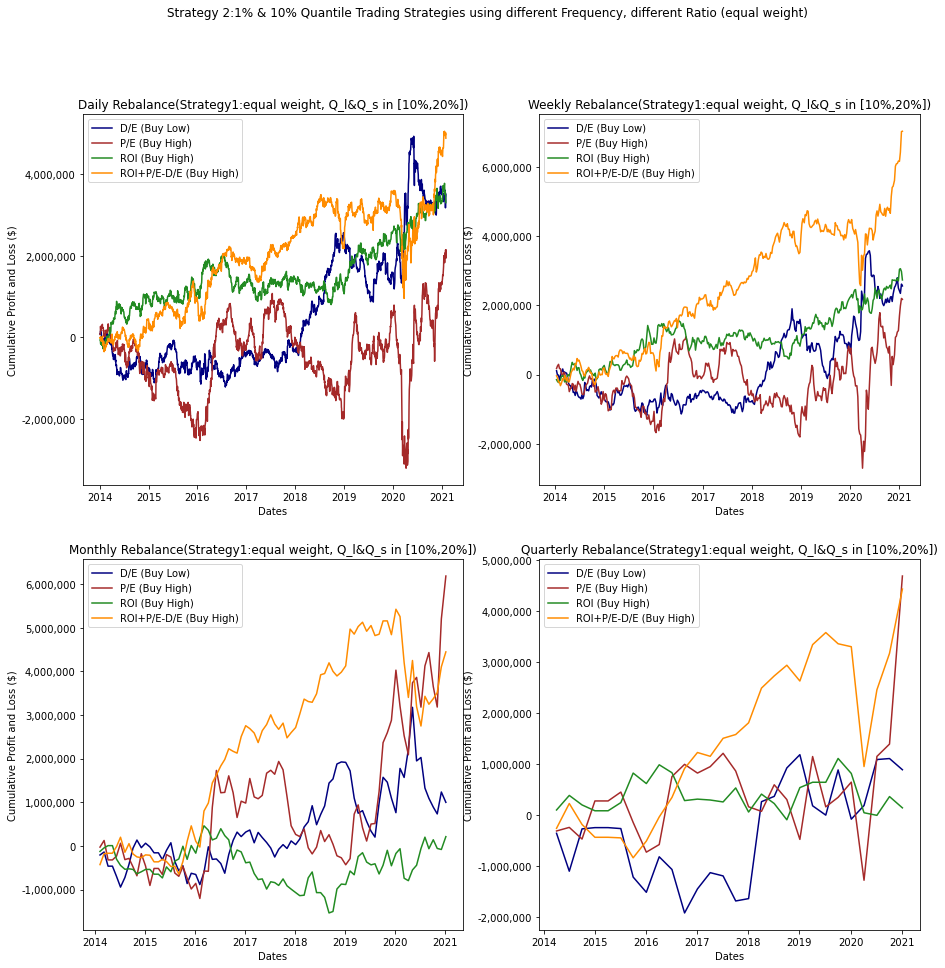

In [83]:
s1dailyplot     = Statistics_ProfitandLoss([DebtEquity_Daily_S1,ReturnOnInvestment_Daily_S1,PriceToEarnings_Daily_S1,Combination_Daily_S1],['DE_1_D1','PE_1_D1','ROI_1_D1','DEROIPE_1_D1']).T
s1weeklyplot    = Statistics_ProfitandLoss([DebtEquity_Weekly_S1,ReturnOnInvestment_Weekly_S1,PriceToEarnings_Weekly_S1,Combination_Weekly_S1],['DE_5_W1','PE_5_W1','ROI_5_W1','DEROIPE_5_W1']).T
s1monthlyplot   = Statistics_ProfitandLoss([DebtEquity_Monthly_S1,ReturnOnInvestment_Monthly_S1,PriceToEarnings_Monthly_S1,Combination_Monthly_S1],['DE_21_M1','PE_21_M1','ROI_21_M1','DEROIPE_21_M1']).T
s1quarterlyplot = Statistics_ProfitandLoss([DebtEquity_Quarterly_S1,ReturnOnInvestment_Quarterly_S1,PriceToEarnings_Quarterly_S1,Combination_Quarterly_S1],['DE_63_Q1','PE_63_Q1','ROI_63_Q1','DEROIPE_63_Q1']).T
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,15))
l1 = ax1.plot(s1dailyplot.index,s1dailyplot['DE_1_D1_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax1.plot(s1dailyplot.index,s1dailyplot['PE_1_D1_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax1.plot(s1dailyplot.index,s1dailyplot['ROI_1_D1_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax1.plot(s1dailyplot.index,s1dailyplot['DEROIPE_1_D1_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax2.plot(s1weeklyplot.index,s1weeklyplot['DE_5_W1_PL_LTD'],label='D/E (Buy Low)', color='navy') l3 = ax2.plot(s1weeklyplot.index,s1weeklyplot['ROI_5_W1_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax2.plot(s1weeklyplot.index,s1weeklyplot['DEROIPE_5_W1_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax3.plot(s1monthlyplot.index,s1monthlyplot['DE_21_M1_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax3.plot(s1monthlyplot.index,s1monthlyplot['PE_21_M1_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax3.plot(s1monthlyplot.index,s1monthlyplot['ROI_21_M1_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax3.plot(s1monthlyplot.index,s1monthlyplot['DEROIPE_21_M1_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax4.plot(s1quarterlyplot.index,s1quarterlyplot['DE_63_Q1_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax4.plot(s1quarterlyplot.index,s1quarterlyplot['PE_63_Q1_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax4.plot(s1quarterlyplot.index,s1quarterlyplot['ROI_63_Q1_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax4.plot(s1quarterlyplot.index,s1quarterlyplot['DEROIPE_63_Q1_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
fig.suptitle('Strategy 2:1% & 10% Quantile Trading Strategies using different Frequency, different Ratio (equal weight)')
ax1.title.set_text('Daily Rebalance(Strategy1:equal weight, Q_l&Q_s in [10%,20%])')
ax2.title.set_text('Weekly Rebalance(Strategy1:equal weight, Q_l&Q_s in [10%,20%])')
ax3.title.set_text('Monthly Rebalance(Strategy1:equal weight, Q_l&Q_s in [10%,20%])')
ax4.title.set_text('Quarterly Rebalance(Strategy1:equal weight, Q_l&Q_s in [10%,20%])')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Cumulative Profit and Loss ($)')
ax1.legend(loc = 'upper left')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Cumulative Profit and Loss ($)')
ax2.legend(loc = 'upper left')
ax3.set_xlabel('Dates')
ax3.set_ylabel('Cumulative Profit and Loss ($)')
ax3.legend(loc = 'upper left')
ax4.set_xlabel('Dates')
ax4.set_ylabel('Cumulative Profit and Loss ($)')
ax4.legend(loc = 'upper left')
ax1.ticklabel_format(useOffset=False, style='plain',axis='y')
ax1.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax4.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
None

## 4.2 Strategy 2: equal weight 
$$ Q_l1 \text{ - "long" (top) quantile} \in [1\%, 20\%] $$
$$ Q_s1 \text{ - "short" (bottom) quantile} \in [1\%, 20\%] $$
$$ H_l1 \text{ - "hold long" quantile variable} < 2Q_l \text{ and } H_l \in (Q_l2, 2Q_l2) $$
$$ H_s1 \text{ - "hold short" quantile variable} > 2Q_s \text{ and } H_s \in (Q_s2, 2Q_s2) $$

### Discussion about different quantile using 1% as threshold

**We found that when we changed our quantile to 1% as entering(buy and sell) threshold, DE ratio with quarterly rebalancing frequency had recorded 34million profit than monthly and quarterly which is higher than using 10% as entering(buy and sell) threshold.**

**We found that ROI performed the worst when we were using 1% as threshold. We thought that it might because ROI is updated daily in the denominator, positive changes in the outlook for the company may make trading on  lower  ROI, which is a better trading strategy. Using 1% as threshold will amplify this problem.**

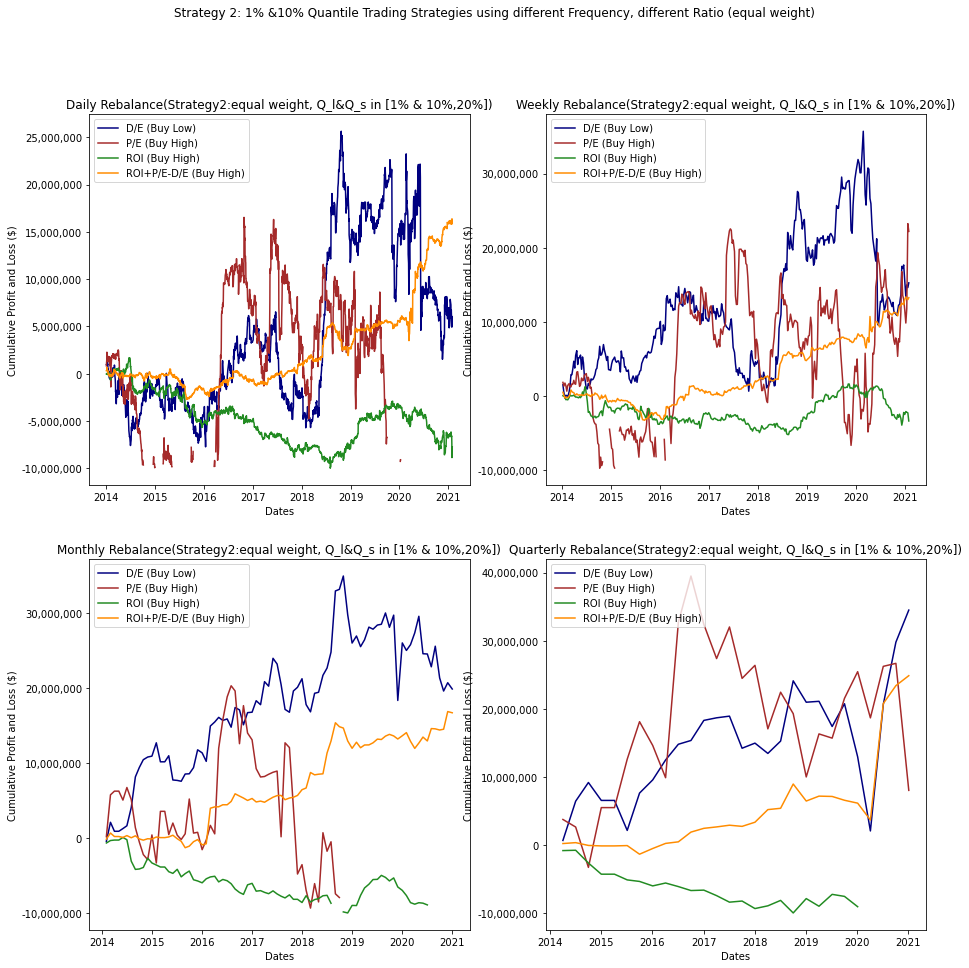

In [84]:
s2edailyplot     = Statistics_ProfitandLoss([DebtEquity_Daily_S2_E,ReturnOnInvestment_Daily_S2_E,PriceToEarnings_Daily_S2_E,Combination_Daily_S2_E],['DE_1_D2E','PE_1_D2E','ROI_1_D2E','DEROIPE_1_D2E']).T
s2eweeklyplot    = Statistics_ProfitandLoss([DebtEquity_Weekly_S2_E,ReturnOnInvestment_Weekly_S2_E,PriceToEarnings_Weekly_S2_E,Combination_Weekly_S2_E],['DE_5_W2E','PE_5_W2E','ROI_5_W2E','DEROIPE_5_W2E']).T
s2emonthlyplot   = Statistics_ProfitandLoss([DebtEquity_Monthly_S2_E,ReturnOnInvestment_Monthly_S2_E,PriceToEarnings_Monthly_S2_E,Combination_Monthly_S2_E],['DE_21_M2E','PE_21_M2E','ROI_21_M2E','DEROIPE_21_M2E']).T
s2equarterlyplot = Statistics_ProfitandLoss([DebtEquity_Quarterly_S2_E,ReturnOnInvestment_Quarterly_S2_E,PriceToEarnings_Quarterly_S2_E,Combination_Quarterly_S2_E],['DE_63_Q2E','PE_63_Q2E','ROI_63_Q2E','DEROIPE_63_Q2E']).T
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,15))
l1 = ax1.plot(s2edailyplot.index,s2edailyplot['DE_1_D2E_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax1.plot(s2edailyplot.index,s2edailyplot['PE_1_D2E_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax1.plot(s2edailyplot.index,s2edailyplot['ROI_1_D2E_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax1.plot(s2edailyplot.index,s2edailyplot['DEROIPE_1_D2E_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax2.plot(s2eweeklyplot.index,s2eweeklyplot['DE_5_W2E_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax2.plot(s2eweeklyplot.index,s2eweeklyplot['PE_5_W2E_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax2.plot(s2eweeklyplot.index,s2eweeklyplot['ROI_5_W2E_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax2.plot(s2eweeklyplot.index,s2eweeklyplot['DEROIPE_5_W2E_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax3.plot(s2emonthlyplot.index,s2emonthlyplot['DE_21_M2E_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax3.plot(s2emonthlyplot.index,s2emonthlyplot['PE_21_M2E_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax3.plot(s2emonthlyplot.index,s2emonthlyplot['ROI_21_M2E_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax3.plot(s2emonthlyplot.index,s2emonthlyplot['DEROIPE_21_M2E_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax4.plot(s2equarterlyplot.index,s2equarterlyplot['DE_63_Q2E_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax4.plot(s2equarterlyplot.index,s2equarterlyplot['PE_63_Q2E_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax4.plot(s2equarterlyplot.index,s2equarterlyplot['ROI_63_Q2E_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax4.plot(s2equarterlyplot.index,s2equarterlyplot['DEROIPE_63_Q2E_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
fig.suptitle('Strategy 2: 1% &10% Quantile Trading Strategies using different Frequency, different Ratio (equal weight)')
ax1.title.set_text('Daily Rebalance(Strategy2:equal weight, Q_l&Q_s in [1% & 10%,20%])')
ax2.title.set_text('Weekly Rebalance(Strategy2:equal weight, Q_l&Q_s in [1% & 10%,20%])')
ax3.title.set_text('Monthly Rebalance(Strategy2:equal weight, Q_l&Q_s in [1% & 10%,20%])')
ax4.title.set_text('Quarterly Rebalance(Strategy2:equal weight, Q_l&Q_s in [1% & 10%,20%])')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Cumulative Profit and Loss ($)')
ax1.legend(loc = 'upper left')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Cumulative Profit and Loss ($)')
ax2.legend(loc = 'upper left')
ax3.set_xlabel('Dates')
ax3.set_ylabel('Cumulative Profit and Loss ($)')
ax3.legend(loc = 'upper left')
ax4.set_xlabel('Dates')
ax4.set_ylabel('Cumulative Profit and Loss ($)')
ax4.legend(loc = 'upper left')
ax1.ticklabel_format(useOffset=False, style='plain',axis='y')
ax1.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax4.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
None

## 4.3 Strategy 2: We will give top and bottom 1% will be given 3x the weight of tickers in the 1% to 10% range.
$$ Q_l1 \text{ - "long" (top) quantile} \in [1\%, 20\%] $$
$$ Q_s1 \text{ - "short" (bottom) quantile} \in [1\%, 20\%] $$
$$ Q_l2 \text{ - "long" (top) quantile} \in [10\%, 20\%] $$
$$ Q_s2 \text{ - "short" (bottom) quantile} \in [10\%, 20\%] $$
$$ H_l1 \text{ - "hold long" quantile variable} < 2Q_l \text{ and } H_l \in (Q_l2, 2Q_l2) $$
$$ H_s1 \text{ - "hold short" quantile variable} > 2Q_s \text{ and } H_s \in (Q_s2, 2Q_s2) $$
$$ H_l2 \text{ - "hold long" quantile variable} < 2Q_l \text{ and } H_l \in (Q_l2, 2Q_l2) $$
$$ H_s2 \text{ - "hold short" quantile variable} > 2Q_s \text{ and } H_s \in (Q_s2, 2Q_s2) $$

### Discussion about different size

**We found that when we changed our quantile to 1% as entering(buy and sell) threshold and give top and bottom 1% will be given 3x the weight of tickers in the 1% to 10% range, DE ratio and PE ratio performed relative better than ROI ratio and our combination ratio.** 

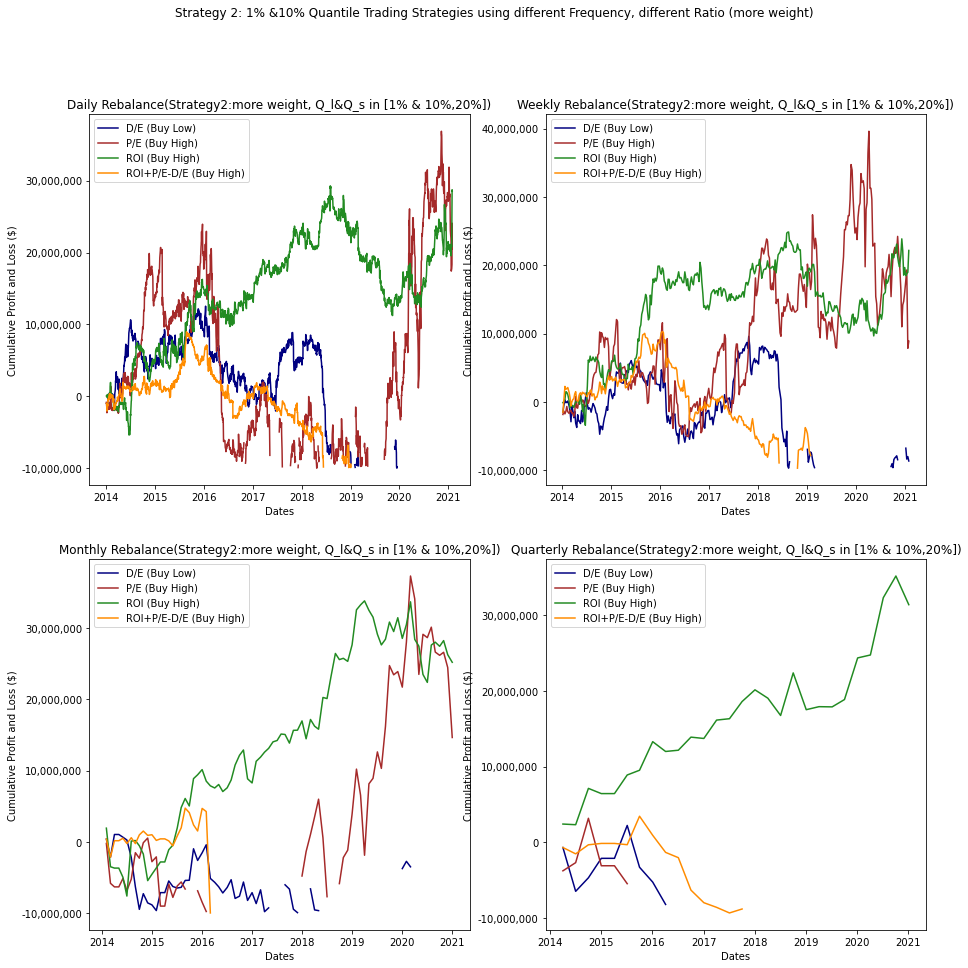

In [85]:
s2hdailyplot     = Statistics_ProfitandLoss([DebtEquity_Daily_S2_H,ReturnOnInvestment_Daily_S2_H,PriceToEarnings_Daily_S2_H,Combination_Daily_S2_H],['DE_1_D2H','PE_1_D2H','ROI_1_D2H','DEROIPE_1_D2H']).T
s2hweeklyplot    = Statistics_ProfitandLoss([DebtEquity_Weekly_S2_H,ReturnOnInvestment_Weekly_S2_H,PriceToEarnings_Weekly_S2_H,Combination_Weekly_S2_H],['DE_5_W2H','PE_5_W2H','ROI_5_W2H','DEROIPE_5_W2H']).T
s2hmonthlyplot   = Statistics_ProfitandLoss([DebtEquity_Monthly_S2_H,ReturnOnInvestment_Monthly_S2_H,PriceToEarnings_Monthly_S2_H,Combination_Monthly_S2_H],['DE_21_M2H','PE_21_M2H','ROI_21_M2H','DEROIPE_21_M2H']).T
s2hquarterlyplot = Statistics_ProfitandLoss([DebtEquity_Quarterly_S2_H,ReturnOnInvestment_Quarterly_S2_H,PriceToEarnings_Quarterly_S2_H,Combination_Quarterly_S2_H],['DE_63_Q2H','PE_63_Q2H','ROI_63_Q2H','DEROIPE_63_Q2H']).T
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,15))
l1 = ax1.plot(s2hdailyplot.index,s2hdailyplot['DE_1_D2H_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax1.plot(s2hdailyplot.index,s2hdailyplot['PE_1_D2H_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax1.plot(s2hdailyplot.index,s2hdailyplot['ROI_1_D2H_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax1.plot(s2hdailyplot.index,s2hdailyplot['DEROIPE_1_D2H_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax2.plot(s2hweeklyplot.index,s2hweeklyplot['DE_5_W2H_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax2.plot(s2hweeklyplot.index,s2hweeklyplot['PE_5_W2H_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax2.plot(s2hweeklyplot.index,s2hweeklyplot['ROI_5_W2H_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax2.plot(s2hweeklyplot.index,s2hweeklyplot['DEROIPE_5_W2H_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax3.plot(s2hmonthlyplot.index,s2hmonthlyplot['DE_21_M2H_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax3.plot(s2hmonthlyplot.index,s2hmonthlyplot['PE_21_M2H_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax3.plot(s2hmonthlyplot.index,s2hmonthlyplot['ROI_21_M2H_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax3.plot(s2hmonthlyplot.index,s2hmonthlyplot['DEROIPE_21_M2H_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
l1 = ax4.plot(s2hquarterlyplot.index,s2hquarterlyplot['DE_63_Q2H_PL_LTD'],label='D/E (Buy Low)', color='navy')
l2 = ax4.plot(s2hquarterlyplot.index,s2hquarterlyplot['PE_63_Q2H_PL_LTD'],label='P/E (Buy High)', color='brown')
l3 = ax4.plot(s2hquarterlyplot.index,s2hquarterlyplot['ROI_63_Q2H_PL_LTD'],label='ROI (Buy High)', color='forestgreen')
l4 = ax4.plot(s2hquarterlyplot.index,s2hquarterlyplot['DEROIPE_63_Q2H_PL_LTD'],label='ROI+P/E-D/E (Buy High)', color='darkorange')
fig.suptitle('Strategy 2: 1% &10% Quantile Trading Strategies using different Frequency, different Ratio (more weight)')
ax1.title.set_text('Daily Rebalance(Strategy2:more weight, Q_l&Q_s in [1% & 10%,20%])')
ax2.title.set_text('Weekly Rebalance(Strategy2:more weight, Q_l&Q_s in [1% & 10%,20%])')
ax3.title.set_text('Monthly Rebalance(Strategy2:more weight, Q_l&Q_s in [1% & 10%,20%])')
ax4.title.set_text('Quarterly Rebalance(Strategy2:more weight, Q_l&Q_s in [1% & 10%,20%])')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Cumulative Profit and Loss ($)')
ax1.legend(loc = 'upper left')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Cumulative Profit and Loss ($)')
ax2.legend(loc = 'upper left')
ax3.set_xlabel('Dates')
ax3.set_ylabel('Cumulative Profit and Loss ($)')
ax3.legend(loc = 'upper left')
ax4.set_xlabel('Dates')
ax4.set_ylabel('Cumulative Profit and Loss ($)')
ax4.legend(loc = 'upper left')
ax1.ticklabel_format(useOffset=False, style='plain',axis='y')
ax1.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax4.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
None

## 4.4 Our Quantile Trading Strategy return statistics

### Quantile Trading Strategy return comparison

**As we can see from the table below, usage of combination of ratios helps us to achieve much better performance on Sharpe ratio and Sortino ratio.** 

**As we can see from the table below, usage of different sizing positions by rank will exacerbate the performance. If the direction is right, it will become the best performer. However, if the direction is wrong, it will become the worst performers which makes sense.**

In [86]:
Statistics(Allpossiblescenario,AllpossiblescenarioString,"Ranking").sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Sortino,Min,Max
ROI_63_Q2H_DailyReturn,0.203,0.217,0.935,1.963,-0.163,0.329
DEROIPE_5_W1_DailyReturn,0.075,0.086,0.874,1.384,-0.048,0.067
DEROIPE_1_D2E_DailyReturn,0.134,0.174,0.773,1.155,-0.058,0.172
DEROIPE_21_M2E_DailyReturn,0.140,0.206,0.682,1.825,-0.093,0.414
DEROIPE_5_W2E_DailyReturn,0.119,0.177,0.668,1.139,-0.093,0.183
DEROIPE_1_D1_DailyReturn,0.056,0.096,0.585,0.747,-0.062,0.049
DEROIPE_21_M1_DailyReturn,0.053,0.092,0.571,0.798,-0.077,0.080
ROI_1_D1_DailyReturn,0.040,0.073,0.551,0.863,-0.021,0.027
DEROIPE_63_Q2E_DailyReturn,0.178,0.340,0.525,1.365,-0.166,0.811
DE_21_M2E_DailyReturn,0.156,0.319,0.490,0.672,-0.337,0.254


### Quantile Trading Strategy risk comparison

**We found that monthly and quarterly rebalancing strategy turns out to be more risky when we were looking at VaR risk statistics.<br>
We also found that daily and weekly rebalancing strategy turns out to be less risky. We can conclude that more frequent rebalancing is beneficial in terms of controlling downside**

In [95]:
Statistics(Allpossiblescenario,AllpossiblescenarioString,"Statistics").sort_values('VaR (Quantile 0.05)')

,Mean,Median,Max,75% Quantile,Min,Std.Dev,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal)
DE_63_Q2H_PL_DLY,-2538725.624,-803058.765,7209182.779,0.000,-18612112.330,5308471.228,-1.016,1.917,-11043188.353,-11270383.777
DEROIPE_63_Q2H_PL_DLY,-2580787.446,-698769.444,7557945.860,192825.549,-51303970.745,10072710.574,-4.268,21.004,-9548304.393,-19148921.966
PE_63_Q2E_PL_DLY,276952.758,0.000,22789825.647,5509428.555,-18644233.673,7830867.436,0.278,1.720,-9309700.681,-12603677.946
PE_21_M2E_PL_DLY,-597911.125,-577225.554,12521804.776,1536312.307,-14899366.232,4807425.890,0.129,1.001,-8706079.666,-8505423.037
PE_21_M2H_PL_DLY,172377.351,422220.735,10010387.669,3032900.106,-12513804.776,4704755.620,-0.313,0.424,-8384692.733,-7566256.995
PE_63_Q2H_PL_DLY,7640.533,-2371699.336,19633501.324,5034706.633,-22815325.647,9117425.298,0.454,1.175,-7207581.242,-14989189.537
DEROIPE_21_M2H_PL_DLY,-689958.022,-340480.532,6302250.147,637138.126,-16365608.367,3235753.330,-2.364,9.352,-6655304.807,-6012298.623
DE_63_Q2E_PL_DLY,1189446.904,675941.537,18557362.330,2950712.716,-10880123.826,5523516.133,0.750,2.858,-6561001.267,-7895928.641
DE_21_M2H_PL_DLY,-309891.269,-102115.922,11390449.584,1092726.198,-15326631.340,3337738.871,-1.187,7.316,-3993669.489,-5799983.157
PE_5_W2H_PL_DLY,24886.199,132687.416,9750530.753,1162569.444,-11463105.742,2372468.090,-0.987,5.564,-3956310.234,-3877476.543


### Quantile Trading Strategy maximum drawdown comparison

**We found that the usage of different sizing positions by rank will exacerbate the performance. If the direction is wrong, it will exacerbate the loss which make sense.**

In [88]:
Statistics(Allpossiblescenario,AllpossiblescenarioString,'Maxdrawdown').sort_values('Max Drawdown')

,Skewness,Excess Kurtosis,VaR (Q0.05),VaR (N0.05),Expected Shortfall,Max Drawdown,Max Drawdown Start,Max Drawdown End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
DEROIPE_21_M2H_DailyReturn,-5.001,25.314,-0.242,-1.979,-2.878,-5.167,2015-09-02,2016-03-04,None,-5.477,2016-03-04,NaN
ROI_1_D2E_DailyReturn,-16.158,611.595,-0.066,-0.197,-0.183,-4.264,2014-06-26,2019-11-08,None,-3.799,2018-08-02,NaN
PE_5_W2E_DailyReturn,-0.586,26.063,-0.356,-0.513,-0.773,-1.926,2014-04-29,2014-10-17,None,-2.549,2014-10-10,NaN
PE_21_M2H_DailyReturn,-1.376,4.349,-0.943,-0.957,-1.782,-1.455,2014-02-03,2015-05-05,None,-2.049,2015-03-05,NaN
ROI_21_M2E_DailyReturn,4.251,35.541,-0.367,-0.850,-0.849,-1.435,2014-06-04,2019-08-06,None,-1.838,2018-12-03,NaN
DE_21_M2H_DailyReturn,-0.350,1.441,-1.833,-1.589,-2.161,-1.388,2014-02-03,2014-10-31,None,-2.642,2017-04-04,NaN
ROI_63_Q2E_DailyReturn,0.383,8.418,-0.961,-2.160,-2.447,-1.173,2014-07-03,2019-01-04,None,-3.931,2018-10-03,NaN
DEROIPE_5_W2H_DailyReturn,4.220,76.697,-0.153,-0.340,-0.400,-1.149,2016-01-20,2018-12-19,None,-1.479,2018-06-07,NaN
DE_5_W2H_DailyReturn,-0.758,21.074,-0.316,-0.471,-0.716,-1.097,2015-03-13,2018-08-10,None,-2.200,2018-08-10,NaN
PE_1_D2H_DailyReturn,-4.284,122.735,-0.229,-0.443,-0.625,-1.017,2015-02-12,2017-07-20,None,-5.293,2018-04-23,NaN


# 5. Conclusion

**In quantile trading strategies, we found that different parameters in ratio combination, trading frequency and size can optimize quantile trading strategies.**

**The best quantile trading strategy that we found was a combination of our z-scores of Debt to Market cap, Return on Investment and Price to Earnings using weekly rebalancing is the most profitable.**

**We discussed Quantile trading using ROI, PE, DE and combination ratios. We could find out although we’re making profits, the performance of the strategy is not that ideal. There’re several ways that may improve the performance of the strategy.** 

**In terms of future optimization, one parameter that was not experimented with the above analysis was using different financial(accounting) ratio and their combination. The second is different enter and hold. This will make the porfolio more dynamic and more flexible to changes in company performance.**

**By finding the optimized parameters, we potentially could also improve the performance of our strategy**